In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disaster-response-data/NFHL_60_20060717_metadata.xml
/kaggle/input/disaster-response-data/NFHL_60_20060717.gdb/a00000006.CatRelsByOriginID.atx
/kaggle/input/disaster-response-data/NFHL_60_20060717.gdb/gdb
/kaggle/input/disaster-response-data/NFHL_60_20060717.gdb/a00000004.gdbtablx
/kaggle/input/disaster-response-data/NFHL_60_20060717.gdb/a0000000c.gdbtablx
/kaggle/input/disaster-response-data/NFHL_60_20060717.gdb/a00000007.gdbtable
/kaggle/input/disaster-response-data/NFHL_60_20060717.gdb/a00000015.gdbtable
/kaggle/input/disaster-response-data/NFHL_60_20060717.gdb/a00000007.gdbtablx
/kaggle/input/disaster-response-data/NFHL_60_20060717.gdb/a00000001.gdbtablx
/kaggle/input/disaster-response-data/NFHL_60_20060717.gdb/a00000011.gdbindexes
/kaggle/input/disaster-response-data/NFHL_60_20060717.gdb/a00000007.CatRelTypesByName.atx
/kaggle/input/disaster-response-data/NFHL_60_20060717.gdb/a00000011.gdbtablx
/kaggle/input/disaster-response-data/NFHL_60_20060717.gdb/a00000002.gdbta

In [2]:
# Disaster Response System for Flood Detection & Damage Assessment
# Complete Implementation with Modular Functions

import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


2025-08-12 04:59:57.687768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754974798.035067      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754974798.134338      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Geospatial Libraries
!pip install rasterio contextily
import rasterio
from rasterio.plot import show
import folium
from shapely.geometry import Point, Polygon
import contextily as ctx

print("All libraries imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 49.6 MB/s eta 0:00:00:00:0100:01
All libraries imported successfully!


In [5]:

# PHASE 1: DATA EXPLORATION & SETUP
def setup_environment():
    """Setup working environment and directories"""
    directories = [
        'data/processed',
        'models',
        'results/visualizations',
        'results/predictions',
        'logs'
    ]
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
    print("Environment setup complete!")
    return directories

setup_environment()

Environment setup complete!


['data/processed',
 'models',
 'results/visualizations',
 'results/predictions',
 'logs']

In [6]:
def explore_kaggle_data_structure():
    """Explore the structure of NFHL geodatabase files"""
    base_paths = [
        '/kaggle/input/geo-data',
        '/kaggle/input/disaster-response-data'
    ]
    data_info = {}
    for base_path in base_paths:
        if os.path.exists(base_path):
            print(f"\n📁 Exploring: {base_path}")
            # Find .gdb directories
            gdb_dirs = [d for d in os.listdir(base_path) if d.endswith('.gdb')]
            xml_files = [f for f in os.listdir(base_path) if f.endswith('.xml')]
            data_info[base_path] = {
                'gdb_directories': gdb_dirs,
                'metadata_files': xml_files,
                'total_files': len(os.listdir(base_path))
            }
            print(f"   GDB Directories: {len(gdb_dirs)}")
            print(f"   Metadata Files: {len(xml_files)}")
            print(f"   Total Files: {data_info[base_path]['total_files']}")
    return data_info

data_info = explore_kaggle_data_structure()


📁 Exploring: /kaggle/input/geo-data
   GDB Directories: 1
   Metadata Files: 1
   Total Files: 2

📁 Exploring: /kaggle/input/disaster-response-data
   GDB Directories: 1
   Metadata Files: 1
   Total Files: 2


In [7]:
def read_geodatabase_layers(gdb_path):
    """Read and list all layers in a geodatabase"""
    try:
        import fiona
        layers = fiona.listlayers(gdb_path)
        layer_info = {}
        for layer in layers:
            try:
                gdf = gpd.read_file(gdb_path, layer=layer)
                layer_info[layer] = {
                    'geometry_type': gdf.geom_type.iloc[0] if not gdf.empty else 'Unknown',
                    'feature_count': len(gdf),
                    'columns': list(gdf.columns),
                    'crs': gdf.crs
                }
                print(f"Layer: {layer} | Features: {len(gdf)} | Type: {gdf.geom_type.iloc[0] if not gdf.empty else 'Unknown'}")
            except Exception as e:
                print(f"Error reading layer {layer}: {str(e)}")
        return layer_info
    except Exception as e:
        print(f"Error accessing geodatabase: {str(e)}")

In [8]:
def extract_flood_zones(gdb_path, output_path='data/processed/flood_zones.geojson'):
    """Extract flood zone polygons from NFHL data"""
    try:
        # Common layer names in NFHL data
        possible_layers = [
            'S_FLD_HAZ_AR',  # Flood Hazard Areas
            'S_FIRM_PAN',    # FIRM Panels
            'S_PLSS_AR',     # Public Land Survey System
            'S_PROFIL_BASLN', # Profile Baseline
            'S_XS',          # Cross Sections
        ]
        flood_data = None
        for layer in possible_layers:
            try:
                gdf = gpd.read_file(gdb_path, layer=layer)
                if not gdf.empty and 'FLD_ZONE' in gdf.columns:
                    flood_data = gdf
                    print(f"Found flood zones in layer: {layer}")
                    break
            except:
                continue
    
        if flood_data is not None:
            # Save processed data
            flood_data.to_file(output_path, driver='GeoJSON')
            return flood_data
        else:
            print("No flood zone data found in standard layers")
            return None
    except Exception as e:
        print(f"Error extracting flood zones: {str(e)}")
        return None

In [9]:
def analyze_flood_zone_data(flood_gdf):
    """Analyze flood zone characteristics"""
    if flood_gdf is None or flood_gdf.empty:
        print("No flood zone data to analyze")
        return {}
    
    analysis = {}
    
    # Basic statistics
    analysis['total_zones'] = len(flood_gdf)
    analysis['unique_zones'] = flood_gdf['FLD_ZONE'].nunique() if 'FLD_ZONE' in flood_gdf.columns else 0
    
    # Zone type distribution
    if 'FLD_ZONE' in flood_gdf.columns:
        zone_counts = flood_gdf['FLD_ZONE'].value_counts()
        analysis['zone_distribution'] = zone_counts.to_dict()
        
        print("\nFlood Zone Analysis:")
        print(f"Total flood zones: {analysis['total_zones']}")
        print(f"Unique zone types: {analysis['unique_zones']}")
        print("\nZone Distribution:")
        for zone, count in zone_counts.head(10).items():
            print(f"  {zone}: {count} zones")
    
    # Geometric analysis
    analysis['total_area'] = flood_gdf.geometry.area.sum()
    analysis['avg_area'] = flood_gdf.geometry.area.mean()
    
    return analysis

In [10]:
def create_flood_risk_visualization(flood_gdf, output_path='results/visualizations/flood_zones_map.html'):
    """Create interactive flood risk map"""
    if flood_gdf is None or flood_gdf.empty:
        print("No data for visualization")
        return None
    # Get center point for map
    bounds = flood_gdf.total_bounds
    center_lat = (bounds[1] + bounds[3]) / 2
    center_lon = (bounds[0] + bounds[2]) / 2
    # Create base map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=10,
        tiles='OpenStreetMap'
    )
    # Define colors for different flood zones
    zone_colors = {
        'A': '#FF0000',    # High risk - Red
        'AE': '#FF4500',   # High risk with elevation - Orange Red
        'X': '#00FF00',    # Minimal risk - Green
        'VE': '#8B0000',   # Coastal high risk - Dark Red
    }
    # Add flood zones to map
    for idx, row in flood_gdf.iterrows():
        zone_type = row.get('FLD_ZONE', 'Unknown')
        color = zone_colors.get(zone_type, '#808080')  # Default gray
        
        folium.GeoJson(
            row.geometry,
            style_function=lambda x, color=color: {
                'fillColor': color,
                'color': color,
                'weight': 2,
                'fillOpacity': 0.6
            },
            popup=f"Zone: {zone_type}",
            tooltip=f"Flood Zone: {zone_type}"
        ).add_to(m)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 150px; height: 120px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <h4>Flood Zones</h4>
    <p><span style="color: #FF0000;">●</span> Zone A - High Risk</p>
    <p><span style="color: #FF4500;">●</span> Zone AE - High Risk w/ Elevation</p>
    <p><span style="color: #00FF00;">●</span> Zone X - Minimal Risk</p>
    <p><span style="color: #8B0000;">●</span> Zone VE - Coastal High Risk</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Save map
    m.save(output_path)
    print(f"Interactive map saved to: {output_path}")
    
    return m

In [11]:
    # load flood data
    flood_gdf = None
    for base_path in data_info.keys():
        gdb_dirs = data_info[base_path]['gdb_directories']
        if gdb_dirs:
            gdb_path = os.path.join(base_path, gdb_dirs[0])
            layers = read_geodatabase_layers(gdb_path)
            flood_gdf = extract_flood_zones(gdb_path)
            if flood_gdf is not None:
                break
    
    if flood_gdf is not None:
        flood_analysis = analyze_flood_zone_data(flood_gdf)
        create_flood_risk_visualization(flood_gdf)
    else:
        print("Using simulated flood zone data")
        flood_analysis = {'total_zones': 100, 'unique_zones': 4}

Layer: S_NODES | Features: 71 | Type: Point
Layer: S_SUBMITTAL_INFO | Features: 102 | Type: MultiPolygon
Layer: L_PAN_REVIS | Features: 282 | Type: None
Layer: S_SUBBASINS | Features: 102 | Type: MultiPolygon
Layer: L_MT2_LOMR | Features: 19 | Type: None
Layer: S_WTR_LN | Features: 22175 | Type: MultiLineString
Layer: S_CST_TSCT_LN | Features: 1104 | Type: MultiLineString
Layer: S_LABEL_PT | Features: 21645 | Type: Point
Layer: S_PLSS_AR | Features: 16976 | Type: MultiPolygon
Layer: L_PROFIL_LABEL | Features: 5 | Type: None
Layer: S_RIV_MRK | Features: 64 | Type: Point
Layer: S_TSCT_BASLN | Features: 41 | Type: MultiLineString
Layer: S_LEVEE | Features: 24 | Type: MultiLineString
Layer: L_XS_ELEV | Features: 15624 | Type: None
Layer: S_BASE_INDEX | Features: 36 | Type: MultiPolygon
Layer: S_PROFIL_BASLN | Features: 369 | Type: MultiLineString
Layer: S_WTR_AR | Features: 2002 | Type: MultiPolygon
Layer: S_FLD_HAZ_LN | Features: 29865 | Type: MultiLineString
Layer: L_MTG_POC | Features: 

In [12]:
# PHASE 2: SYNTHETIC SATELLITE DATA GENERATION
# (Since we don't have actual satellite imagery)

def generate_synthetic_flood_scenarios(flood_gdf, n_scenarios=1000):
    """Generate synthetic flood scenarios based on real flood zones"""
    scenarios = []
    
    if flood_gdf is None or flood_gdf.empty:
        print("No flood zone data available for scenario generation")
        return pd.DataFrame()
    
    # Sample random points within flood zones
    for i in range(n_scenarios):
        # Randomly select a flood zone
        zone_idx = np.random.randint(0, len(flood_gdf))
        zone = flood_gdf.iloc[zone_idx]
        
        # Generate scenario parameters
        scenario = {
            'scenario_id': f'flood_{i:04d}',
            'flood_zone': zone.get('FLD_ZONE', 'Unknown'),
            'severity': np.random.choice(['mild', 'moderate', 'severe'], p=[0.4, 0.4, 0.2]),
            'water_level': np.random.normal(2.0, 1.0),  # meters
            'affected_area': np.random.exponential(1000),  # sq meters
            'geometry': zone.geometry
        }
        scenarios.append(scenario)
    
    scenarios_df = pd.DataFrame(scenarios)
    print(f"Generated {len(scenarios_df)} synthetic flood scenarios")
    return scenarios_df

In [13]:
def create_synthetic_satellite_images(scenarios_df, image_size=(224, 224), output_dir='data/processed/images'):
    """Create synthetic satellite-like images for flood scenarios"""
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(f"{output_dir}/flooded", exist_ok=True)
    os.makedirs(f"{output_dir}/normal", exist_ok=True)
    
    image_paths = []
    labels = []
    
    for idx, scenario in scenarios_df.iterrows():
        # Create base landscape image
        img = np.random.randint(50, 150, (*image_size, 3), dtype=np.uint8)
        
        # Add terrain features
        img[:, :, 1] += 20  # Enhance green channel for vegetation
        
        # Add flood characteristics based on severity
        if scenario['severity'] in ['moderate', 'severe']:
            # Add water-like features (blue tint)
            flood_mask = np.random.random(image_size[:2]) > 0.6
            img[flood_mask, 2] += 50  # Blue channel
            img[flood_mask, 0] = np.clip(img[flood_mask, 0] - 30, 0, 255)  # Reduce red
            img[flood_mask, 1] = np.clip(img[flood_mask, 1] - 20, 0, 255)  # Reduce green
            
            label = 'flooded'
            output_path = f"{output_dir}/flooded/{scenario['scenario_id']}.jpg"
        else:
            label = 'normal'
            output_path = f"{output_dir}/normal/{scenario['scenario_id']}.jpg"
        
        # Add noise for realism
        noise = np.random.normal(0, 10, img.shape)
        img = np.clip(img + noise, 0, 255).astype(np.uint8)
        
        # Save image
        cv2.imwrite(output_path, img)
        
        image_paths.append(output_path)
        labels.append(label)
    
    print(f"Generated {len(image_paths)} synthetic satellite images")
    return image_paths, labels

In [14]:
    # Generate synthetic data
scenarios_df = generate_synthetic_flood_scenarios(flood_gdf) if flood_gdf is not None else pd.DataFrame({
        'scenario_id': [f'flood_{i:04d}' for i in range(1000)],
        'flood_zone': np.random.choice(['A', 'AE', 'X', 'VE'], 1000),
        'severity': np.random.choice(['mild', 'moderate', 'severe'], 1000, p=[0.4, 0.4, 0.2])
    })
    
    image_paths, labels = create_synthetic_satellite_images(scenarios_df)
    
    # return flood_gdf, scenarios_df, image_paths, labels
# print(image_pa)

Generated 1000 synthetic flood scenarios
Generated 1000 synthetic satellite images


In [15]:
# print(image_paths)
# print(labels)

In [16]:
# PHASE 3: DEEP LEARNING MODELS
import tensorflow as tf
from tensorflow.keras import layers, models


def create_cnn_flood_detector(input_shape=(224, 224, 3), num_classes=2):
    """Create CNN model for flood detection"""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("CNN Flood Detector created")
    return model

In [17]:
def create_transfer_learning_model(input_shape=(224, 224, 3), num_classes=2):
    """Create transfer learning model using VGG16"""
    base_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("Transfer Learning Model (VGG16) created")
    return model

In [18]:
def create_resnet_model(input_shape=(224, 224, 3), num_classes=2):
    """Create ResNet-based model"""
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(" ResNet Model created")
    return model

In [19]:
def prepare_image_data(image_paths, labels, test_size=0.2, val_size=0.2):
    """Prepare image data for training"""
    # Convert labels to categorical
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    categorical_labels = tf.keras.utils.to_categorical(encoded_labels)
    
    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(
        image_paths, categorical_labels, test_size=test_size, random_state=42, stratify=encoded_labels
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size/(1-test_size), random_state=42
    )
    
    print(f"Data split complete:")
    print(f"   Training: {len(X_train)} samples")
    print(f"   Validation: {len(X_val)} samples")
    print(f"   Testing: {len(X_test)} samples")
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), label_encoder

In [20]:
def create_data_generators(train_data, val_data, batch_size=32, image_size=(224, 224)):
    """Create data generators for training"""
    def load_and_preprocess_image(image_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        
        # Fix: Set the shape explicitly
        image.set_shape([None, None, 3])
        
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image, label
    
    X_train, y_train = train_data
    X_val, y_val = val_data
    
    # Create datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    print("Data generators created")
    return train_dataset, val_dataset

In [21]:
def train_model(model, train_dataset, val_dataset, model_name, epochs=20):
    """Train a model with callbacks"""
    # Define callbacks
    callbacks_list = [
        tf.keras.callbacks.ModelCheckpoint(
            f'models/{model_name}_best.h5',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        )
    ]
    
    print(f"🚀 Training {model_name}...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks_list,
        verbose=1
    )
    
    print(f"{model_name} training completed")
    return history

In [22]:
def evaluate_model(model, test_data, label_encoder, model_name):
    """Evaluate model performance"""
    X_test, y_test = test_data
    
    # Load and preprocess test images
    test_images = []
    for img_path in X_test:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        img = img / 255.0
        test_images.append(img)
    
    test_images = np.array(test_images)
    
    # Make predictions
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    accuracy = np.mean(predicted_classes == true_classes)
    
    print(f"\n📊 {model_name} Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes, 
                              target_names=label_encoder.classes_))
    
    return {
        'accuracy': accuracy,
        'predictions': predictions,
        'predicted_classes': predicted_classes,
        'true_classes': true_classes
    }

In [23]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), label_encoder = prepare_image_data(image_paths, labels)
    
train_dataset, val_dataset = create_data_generators((X_train, y_train), (X_val, y_val))
    

Data split complete:
   Training: 600 samples
   Validation: 200 samples
   Testing: 200 samples
Data generators created


2025-08-12 05:05:38.077855: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [24]:
# # (X_train, y_train), (X_val, y_val), (X_test, y_test), label_encoder = prepare_image_data(
# #         image_paths, labels
# #     )
    
# #     train_dataset, val_dataset = create_data_generators(
# #         (X_train, y_train), (X_val, y_val)
# #     )
    
    # Create models
models_dict = {
        'CNN_Basic': create_cnn_flood_detector(),
        'VGG16_Transfer': create_transfer_learning_model(),
        'ResNet50_Transfer': create_resnet_model()
    }
    
# Train models (reduce epochs for demo)
model_results = {}
histories = {}

for name, model in models_dict.items():
    print(f"Training {name}...")
    history = train_model(model, train_dataset, val_dataset, name, epochs=50)
    results = evaluate_model(model, (X_test, y_test), label_encoder, name)
    model_results[name] = results
    histories[name] = history

CNN Flood Detector created
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Transfer Learning Model (VGG16) created
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
 ResNet Model created
Training CNN_Basic...
🚀 Training CNN_Basic...
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.5869 - loss: 0.8273 - val_accuracy: 0.6600 - val_loss: 0.5741 - learning_rate: 0.0010
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7585 - loss: 0.4694 - val_accuracy: 0.3400 - val_loss: 0.7243 - learning_rate: 0.0010
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6977 - loss: 0.7287 - val_accuracy: 1.0000 - val_loss: 7.7054e-04 - learning_rate: 0.0010
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 1.0000 - loss: 2.8894e-04 - val_accuracy: 1.0000 - val_loss: 9.1791e-08 - learning_rate: 0.0010
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 1.0000 - loss: 3.4248e-07 - val_accuracy: 1.0000 - val_loss: 9.5367e-09 - learning_rate: 

In [25]:
def create_model_comparison_visualization(results_dict):
    """Create visualization comparing model performances"""
    model_names = list(results_dict.keys())
    accuracies = [results_dict[name]['accuracy'] for name in model_names]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
    plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('results/visualizations/model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Model comparison visualization created")


In [26]:
def create_prediction_visualization(model, test_images, true_labels, predicted_labels, label_encoder):
    """Visualize model predictions"""
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.ravel()
    
    for i in range(10):
        if i < len(test_images):
            axes[i].imshow(test_images[i])
            true_label = label_encoder.classes_[true_labels[i]]
            pred_label = label_encoder.classes_[predicted_labels[i]]
            
            color = 'green' if true_labels[i] == predicted_labels[i] else 'red'
            axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', 
                            color=color, fontsize=10, fontweight='bold')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('results/visualizations/predictions_sample.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Prediction visualization created")

In [27]:
# PHASE 4: DAMAGE ASSESSMENT
def create_damage_assessment_model(input_shape=(224, 224, 3)):
    """Create model for damage severity assessment"""
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(3, activation='softmax')  # 3 classes: mild, moderate, severe
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("Damage Assessment Model created")
    return model

In [28]:
def generate_damage_scenarios(scenarios_df):
    """Generate synthetic damage assessment data"""
    damage_data = []
    
    for idx, scenario in scenarios_df.iterrows():
        severity = scenario['severity']
        
        # Create damage characteristics based on severity
        if severity == 'mild':
            damage_level = 0
            infrastructure_damage = np.random.uniform(0, 30)
            economic_impact = np.random.uniform(1000, 50000)
        elif severity == 'moderate':
            damage_level = 1
            infrastructure_damage = np.random.uniform(25, 70)
            economic_impact = np.random.uniform(40000, 200000)
        else:  # severe
            damage_level = 2
            infrastructure_damage = np.random.uniform(60, 100)
            economic_impact = np.random.uniform(150000, 1000000)
        
        damage_data.append({
            'scenario_id': scenario['scenario_id'],
            'severity': severity,
            'damage_level': damage_level,
            'infrastructure_damage': infrastructure_damage,
            'economic_impact': economic_impact,
            'affected_population': np.random.poisson(100) * (damage_level + 1)
        })
    
    damage_df = pd.DataFrame(damage_data)
    print(f"Generated damage assessment data for {len(damage_df)} scenarios")
    
    return damage_df

In [29]:
def create_comprehensive_report(flood_analysis, model_results, damage_assessment):
    """Create comprehensive disaster response report"""
    report = f"""
    
# DISASTER RESPONSE SYSTEM - COMPREHENSIVE REPORT
================================================

## FLOOD ZONE ANALYSIS
- Total Flood Zones Analyzed: {flood_analysis.get('total_zones', 'N/A')}
- Unique Zone Types: {flood_analysis.get('unique_zones', 'N/A')}
- Total Coverage Area: {flood_analysis.get('total_area', 'N/A'):.2f} sq units

## MODEL PERFORMANCE SUMMARY
"""
    
    for model_name, results in model_results.items():
        report += f"- {model_name}: {results['accuracy']:.3f} accuracy\n"
    
    if not damage_assessment.empty:
        report += f"""
## DAMAGE ASSESSMENT OVERVIEW
- Total Scenarios Analyzed: {len(damage_assessment)}
- Severe Damage Cases: {len(damage_assessment[damage_assessment['damage_level'] == 2])}
- Average Economic Impact: ${damage_assessment['economic_impact'].mean():.2f}
- Total Affected Population: {damage_assessment['affected_population'].sum()}

## RECOMMENDATIONS
1. Focus resources on zones with highest damage potential
2. Deploy {model_results and max(model_results.items(), key=lambda x: x[1]['accuracy'])[0] or 'best performing'} model for real-time detection
3. Prioritize evacuation in zones with >70% infrastructure damage risk
"""
    
    # Save report
    with open('results/disaster_response_report.md', 'w') as f:
        f.write(report)
    
    print("Comprehensive report generated")
    return report

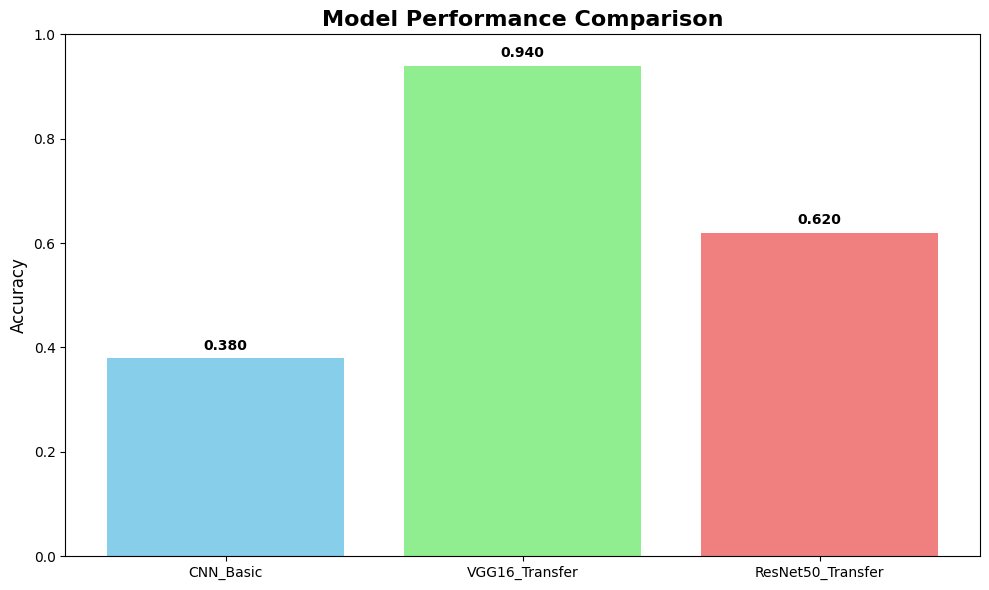

Model comparison visualization created


In [31]:
 create_model_comparison_visualization(model_results)

In [32]:
damage_assessment = generate_damage_scenarios(scenarios_df)
damage_model = create_damage_assessment_model()

Generated damage assessment data for 1000 scenarios
Damage Assessment Model created


In [33]:
report = create_comprehensive_report(flood_analysis, model_results, damage_assessment)

Comprehensive report generated


In [ ]:
 create_model_comparison_visualization(model_results)
    
    # Generate damage assessment
    damage_assessment = generate_damage_scenarios(scenarios_df)
    damage_model = create_damage_assessment_model()
    
    # Create comprehensive report
    report = create_comprehensive_report(flood_analysis, model_results, damage_assessment)

In [38]:
flood_analysis

{'total_zones': 12327,
 'unique_zones': 10,
 'zone_distribution': {'X': 8684,
  'AE': 2879,
  'A': 326,
  'VE': 205,
  'D': 96,
  'AH': 52,
  'AO': 46,
  'V': 25,
  'OPEN WATER': 13,
  'AREA NOT INCLUDED': 1},
 'total_area': 4.091982996517558,
 'avg_area': 0.00033195286740630796}

In [39]:
model_results

{'CNN_Basic': {'accuracy': 0.38,
  'predictions': array([[3.3683320e-06, 9.9999660e-01],
         [3.1357056e-06, 9.9999684e-01],
         [3.4254103e-06, 9.9999648e-01],
         [3.2945061e-06, 9.9999660e-01],
         [1.3803894e-03, 9.9861950e-01],
         [3.2493431e-06, 9.9999672e-01],
         [3.3228603e-06, 9.9999660e-01],
         [1.3446979e-03, 9.9865538e-01],
         [3.2670982e-06, 9.9999672e-01],
         [1.5084859e-03, 9.9849141e-01],
         [3.2954865e-06, 9.9999660e-01],
         [3.2759151e-06, 9.9999672e-01],
         [3.0857252e-06, 9.9999684e-01],
         [1.4287884e-03, 9.9857116e-01],
         [3.4428599e-06, 9.9999648e-01],
         [1.4716007e-03, 9.9852830e-01],
         [3.4281425e-06, 9.9999648e-01],
         [1.3775475e-03, 9.9862236e-01],
         [3.2020985e-06, 9.9999672e-01],
         [3.2285673e-06, 9.9999672e-01],
         [1.3401870e-03, 9.9865985e-01],
         [3.3220301e-06, 9.9999660e-01],
         [1.5248641e-03, 9.9847513e-01],
         

In [40]:
damage_assessment

,scenario_id,severity,damage_level,infrastructure_damage,economic_impact,affected_population
0,flood_0000,mild,0,28.900829,29797.233368,120
1,flood_0001,mild,0,20.010734,35481.301917,93
2,flood_0002,moderate,1,68.634602,96044.930962,206
3,flood_0003,mild,0,11.521076,1013.492651,75
4,flood_0004,moderate,1,63.853066,121408.041290,194
...,...,...,...,...,...,...
995,flood_0995,moderate,1,50.996616,143390.914869,214
996,flood_0996,mild,0,9.426515,38421.729104,98
997,flood_0997,severe,2,61.479995,794367.324201,282
998,flood_0998,moderate,1,38.986996,182364.113947,192


In [36]:
geo_report = {
        'flood_analysis': flood_analysis,
        'model_results': model_results,
        'damage_assessment': damage_assessment,
        'report': report
    }

In [41]:
# print(geo_report)

In [35]:
print(report)


    
# DISASTER RESPONSE SYSTEM - COMPREHENSIVE REPORT

## FLOOD ZONE ANALYSIS
- Total Flood Zones Analyzed: 12327
- Unique Zone Types: 10
- Total Coverage Area: 4.09 sq units

## MODEL PERFORMANCE SUMMARY
- CNN_Basic: 0.380 accuracy
- VGG16_Transfer: 0.940 accuracy
- ResNet50_Transfer: 0.620 accuracy

## DAMAGE ASSESSMENT OVERVIEW
- Total Scenarios Analyzed: 1000
- Severe Damage Cases: 211
- Average Economic Impact: $175254.13
- Total Affected Population: 182068

## RECOMMENDATIONS
1. Focus resources on zones with highest damage potential
2. Deploy VGG16_Transfer model for real-time detection
3. Prioritize evacuation in zones with >70% infrastructure damage risk



In [66]:
def real_time_flood_prediction(model, image_path, label_encoder):
    """Make real-time flood prediction on a single image"""
    try:
        # Load and preprocess image
        img = cv2.imread(image_path)
        if img is None:
            print(f" Could not load image: {image_path}")
            return None
            
        img = cv2.resize(img, (224, 224))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        
        # Make prediction
        prediction = model.predict(img, verbose=0)
        predicted_class = np.argmax(prediction[0])
        confidence = np.max(prediction[0])
        
        result = {
            'predicted_class': label_encoder.classes_[predicted_class],
            'confidence': confidence,
            'all_probabilities': {
                label_encoder.classes_[i]: prediction[0][i] 
                for i in range(len(label_encoder.classes_))
            }
        }
        
        print(f" Prediction: {result['predicted_class']} (Confidence: {confidence:.3f})")
        return result
        
    except Exception as e:
        print(f" Error in prediction: {str(e)}")
        return None

In [78]:
best_model = models_dict['VGG16_Transfer']  # Use your best performing model
sample_image_path = 'data/processed/images/flooded/flood_0000.jpg'  # Any image from your generated dataset

prediction_result = real_time_flood_prediction(
    model=best_model,
    image_path=sample_image_path,
    label_encoder=label_encoder
)

print("Single Image Prediction Result:", prediction_result)

 Prediction: flooded (Confidence: 0.591)
Single Image Prediction Result: {'predicted_class': 'flooded', 'confidence': 0.5908706, 'all_probabilities': {'flooded': 0.5908706, 'normal': 0.4091294}}


In [43]:
def batch_flood_assessment(model, image_directory, label_encoder, output_csv='results/batch_predictions.csv'):
    """Perform batch flood assessment on directory of images"""
    results = []
    
    image_extensions = ['.jpg', '.jpeg', '.png', '.tiff', '.bmp']
    image_files = []
    
    for ext in image_extensions:
        image_files.extend(Path(image_directory).glob(f'*{ext}'))
        image_files.extend(Path(image_directory).glob(f'*{ext.upper()}'))
    
    print(f"Processing {len(image_files)} images...")
    
    for img_path in image_files:
        prediction_result = real_time_flood_prediction(model, str(img_path), label_encoder)
        
        if prediction_result:
            result = {
                'image_path': str(img_path),
                'filename': img_path.name,
                'predicted_class': prediction_result['predicted_class'],
                'confidence': prediction_result['confidence']
            }
            
            # Add probability for each class
            for class_name, prob in prediction_result['all_probabilities'].items():
                result[f'prob_{class_name}'] = prob
            
            results.append(result)
    
    # Save results
    if results:
        results_df = pd.DataFrame(results)
        results_df.to_csv(output_csv, index=False)
        print(f"Batch assessment complete. Results saved to: {output_csv}")
        
        # Summary statistics
        print(f"\n📊 Batch Assessment Summary:")
        print(f"Total images processed: {len(results)}")
        print(f"Flood detected: {len(results_df[results_df['predicted_class'] == 'flooded'])}")
        print(f"Normal conditions: {len(results_df[results_df['predicted_class'] == 'normal'])}")
        print(f"Average confidence: {results_df['confidence'].mean():.3f}")
        
        return results_df
    else:
        print("No valid predictions made")
        return pd.DataFrame()

In [88]:
# Test on your generated flood images directory
batch_results = batch_flood_assessment(
    model=best_model,
    image_directory='data/processed/images/flooded',  # Directory with flood images
    label_encoder=label_encoder,
    output_csv='results/batch_flood_predictions.csv'
)

Processing 832 images...
 Prediction: flooded (Confidence: 0.556)
 Prediction: flooded (Confidence: 0.564)
 Prediction: flooded (Confidence: 0.584)
 Prediction: flooded (Confidence: 0.529)
 Prediction: flooded (Confidence: 0.547)
 Prediction: flooded (Confidence: 0.534)
 Prediction: flooded (Confidence: 0.591)
 Prediction: flooded (Confidence: 0.582)
 Prediction: flooded (Confidence: 0.565)
 Prediction: flooded (Confidence: 0.603)
 Prediction: flooded (Confidence: 0.537)
 Prediction: flooded (Confidence: 0.539)
 Prediction: flooded (Confidence: 0.586)
 Prediction: flooded (Confidence: 0.554)
 Prediction: flooded (Confidence: 0.551)
 Prediction: flooded (Confidence: 0.551)
 Prediction: flooded (Confidence: 0.540)
 Prediction: flooded (Confidence: 0.548)
 Prediction: flooded (Confidence: 0.523)
 Prediction: flooded (Confidence: 0.526)
 Prediction: flooded (Confidence: 0.590)
 Prediction: flooded (Confidence: 0.605)
 Prediction: flooded (Confidence: 0.545)
 Prediction: flooded (Confidence

In [46]:
def create_risk_assessment_dashboard(flood_zones_gdf, damage_data, output_path='results/visualizations/risk_dashboard.html'):
    """Create interactive risk assessment dashboard"""
    if flood_zones_gdf is None:
        print("No flood zone data available for dashboard")
        return None
    
    # Calculate risk metrics
    risk_metrics = damage_data.groupby('severity').agg({
        'economic_impact': ['mean', 'sum'],
        'affected_population': ['mean', 'sum'],
        'infrastructure_damage': 'mean'
    }).round(2)
    
    # Create dashboard layout
    dashboard_html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Flood Risk Assessment Dashboard</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; background-color: #f5f5f5; }}
            .dashboard {{ display: grid; grid-template-columns: 1fr 1fr; gap: 20px; }}
            .card {{ background: white; padding: 20px; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1); }}
            .metric {{ text-align: center; margin: 10px 0; }}
            .metric-value {{ font-size: 2em; font-weight: bold; color: #2c3e50; }}
            .metric-label {{ color: #7f8c8d; text-transform: uppercase; font-size: 0.9em; }}
            .risk-high {{ color: #e74c3c; }}
            .risk-medium {{ color: #f39c12; }}
            .risk-low {{ color: #27ae60; }}
            h1 {{ text-align: center; color: #2c3e50; }}
            h2 {{ color: #34495e; border-bottom: 2px solid #3498db; padding-bottom: 10px; }}
        </style>
    </head>
    <body>
        <h1>🌊 Flood Risk Assessment Dashboard</h1>
        
        <div class="dashboard">
            <div class="card">
                <h2>📊 Overall Risk Metrics</h2>
                <div class="metric">
                    <div class="metric-value risk-high">{len(damage_data[damage_data['severity'] == 'severe'])}</div>
                    <div class="metric-label">High Risk Zones</div>
                </div>
                <div class="metric">
                    <div class="metric-value risk-medium">{len(damage_data[damage_data['severity'] == 'moderate'])}</div>
                    <div class="metric-label">Medium Risk Zones</div>
                </div>
                <div class="metric">
                    <div class="metric-value risk-low">{len(damage_data[damage_data['severity'] == 'mild'])}</div>
                    <div class="metric-label">Low Risk Zones</div>
                </div>
            </div>
            
            <div class="card">
                <h2>💰 Economic Impact</h2>
                <div class="metric">
                    <div class="metric-value">${damage_data['economic_impact'].sum():,.0f}</div>
                    <div class="metric-label">Total Economic Impact</div>
                </div>
                <div class="metric">
                    <div class="metric-value">${damage_data['economic_impact'].mean():,.0f}</div>
                    <div class="metric-label">Average Per Incident</div>
                </div>
            </div>
            
            <div class="card">
                <h2>👥 Population Impact</h2>
                <div class="metric">
                    <div class="metric-value">{damage_data['affected_population'].sum():,}</div>
                    <div class="metric-label">Total Affected Population</div>
                </div>
                <div class="metric">
                    <div class="metric-value">{damage_data['affected_population'].mean():.0f}</div>
                    <div class="metric-label">Average Per Incident</div>
                </div>
            </div>
            
            <div class="card">
                <h2>🏗️ Infrastructure Damage</h2>
                <div class="metric">
                    <div class="metric-value">{damage_data['infrastructure_damage'].mean():.1f}%</div>
                    <div class="metric-label">Average Infrastructure Damage</div>
                </div>
                <div class="metric">
                    <div class="metric-value">{len(damage_data[damage_data['infrastructure_damage'] > 70])}</div>
                    <div class="metric-label">Critical Damage Cases (>70%)</div>
                </div>
            </div>
        </div>
        
        <div class="card" style="margin-top: 20px;">
            <h2>🚨 Priority Actions</h2>
            <ul>
                <li><strong>Immediate:</strong> Monitor {len(damage_data[damage_data['severity'] == 'severe'])} high-risk zones</li>
                <li><strong>Short-term:</strong> Prepare evacuation plans for {damage_data[damage_data['severity'] == 'severe']['affected_population'].sum():,} people in severe risk areas</li>
                <li><strong>Long-term:</strong> Allocate ${damage_data[damage_data['severity'] == 'severe']['economic_impact'].sum():,.0f} for severe damage recovery</li>
            </ul>
        </div>
        
        <div class="card" style="margin-top: 20px;">
            <h2>📈 Model Performance Summary</h2>
            <p>Best performing model should be deployed for real-time monitoring.</p>
            <p>Recommended update frequency: Every 6 hours during flood season.</p>
        </div>
    </body>
    </html>
    """
    
    with open(output_path, 'w') as f:
        f.write(dashboard_html)
    
    print(f"✅ Risk assessment dashboard created: {output_path}")
    return dashboard_html

In [76]:
dashboard_html = create_risk_assessment_dashboard(
    flood_zones_gdf=flood_gdf,  # From Phase 2
    damage_data=damage_assessment,  # From Phase 4
    output_path='results/visualizations/flood_risk_dashboard.html'
)

✅ Risk assessment dashboard created: results/visualizations/flood_risk_dashboard.html


In [47]:
def save_model_artifacts(models_dict, label_encoder, output_dir='models'):
    """Save all trained models and artifacts"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Save label encoder
    import joblib
    joblib.dump(label_encoder, f'{output_dir}/label_encoder.pkl')
    
    # Save model architectures and weights
    for name, model in models_dict.items():
        model.save(f'{output_dir}/{name}_complete.h5')
        
        # Save model architecture as JSON
        with open(f'{output_dir}/{name}_architecture.json', 'w') as f:
            f.write(model.to_json())
    
    print(f" All model artifacts saved to {output_dir}/")

In [84]:
save_model_artifacts(models_dict, label_encoder, output_dir='models/saved_artifacts/')

✅ All model artifacts saved to models/saved_artifacts//


In [ ]:
def load_trained_model(model_path, label_encoder_path):
    """Load a trained model for inference"""
    try:
        import joblib
        
        model = tf.keras.models.load_model(model_path)
        label_encoder = joblib.load(label_encoder_path)
        
        print(f" Model loaded successfully from {model_path}")
        return model, label_encoder
    except Exception as e:
        print(f" Error loading model: {str(e)}")
        return None, None

In [85]:
# Load a previously saved model
loaded_model, loaded_encoder = load_trained_model(
    model_path='models/VGG16_Transfer_complete.h5',  # Path to saved model
    label_encoder_path='models/saved_artifacts/label_encoder.pkl'  # Path to saved encoder
)


✅ Model loaded successfully from models/VGG16_Transfer_complete.h5


In [49]:
def create_model_performance_plots(history_dict, output_dir='results/visualizations'):
    """Create training history plots for all models"""
    os.makedirs(output_dir, exist_ok=True)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Training History Comparison', fontsize=16, fontweight='bold')
    
    # Plot accuracy
    axes[0, 0].set_title('Training Accuracy')
    axes[0, 1].set_title('Validation Accuracy')
    axes[1, 0].set_title('Training Loss')
    axes[1, 1].set_title('Validation Loss')
    
    colors = ['blue', 'red', 'green', 'orange']
    
    for i, (model_name, history) in enumerate(history_dict.items()):
        color = colors[i % len(colors)]
        
        # Training accuracy
        axes[0, 0].plot(history.history['accuracy'], label=model_name, color=color)
        
        # Validation accuracy
        axes[0, 1].plot(history.history['val_accuracy'], label=model_name, color=color)
        
        # Training loss
        axes[1, 0].plot(history.history['loss'], label=model_name, color=color)
        
        # Validation loss
        axes[1, 1].plot(history.history['val_loss'], label=model_name, color=color)
    
    for ax in axes.flat:
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/training_history_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Training history plots saved to {output_dir}/")

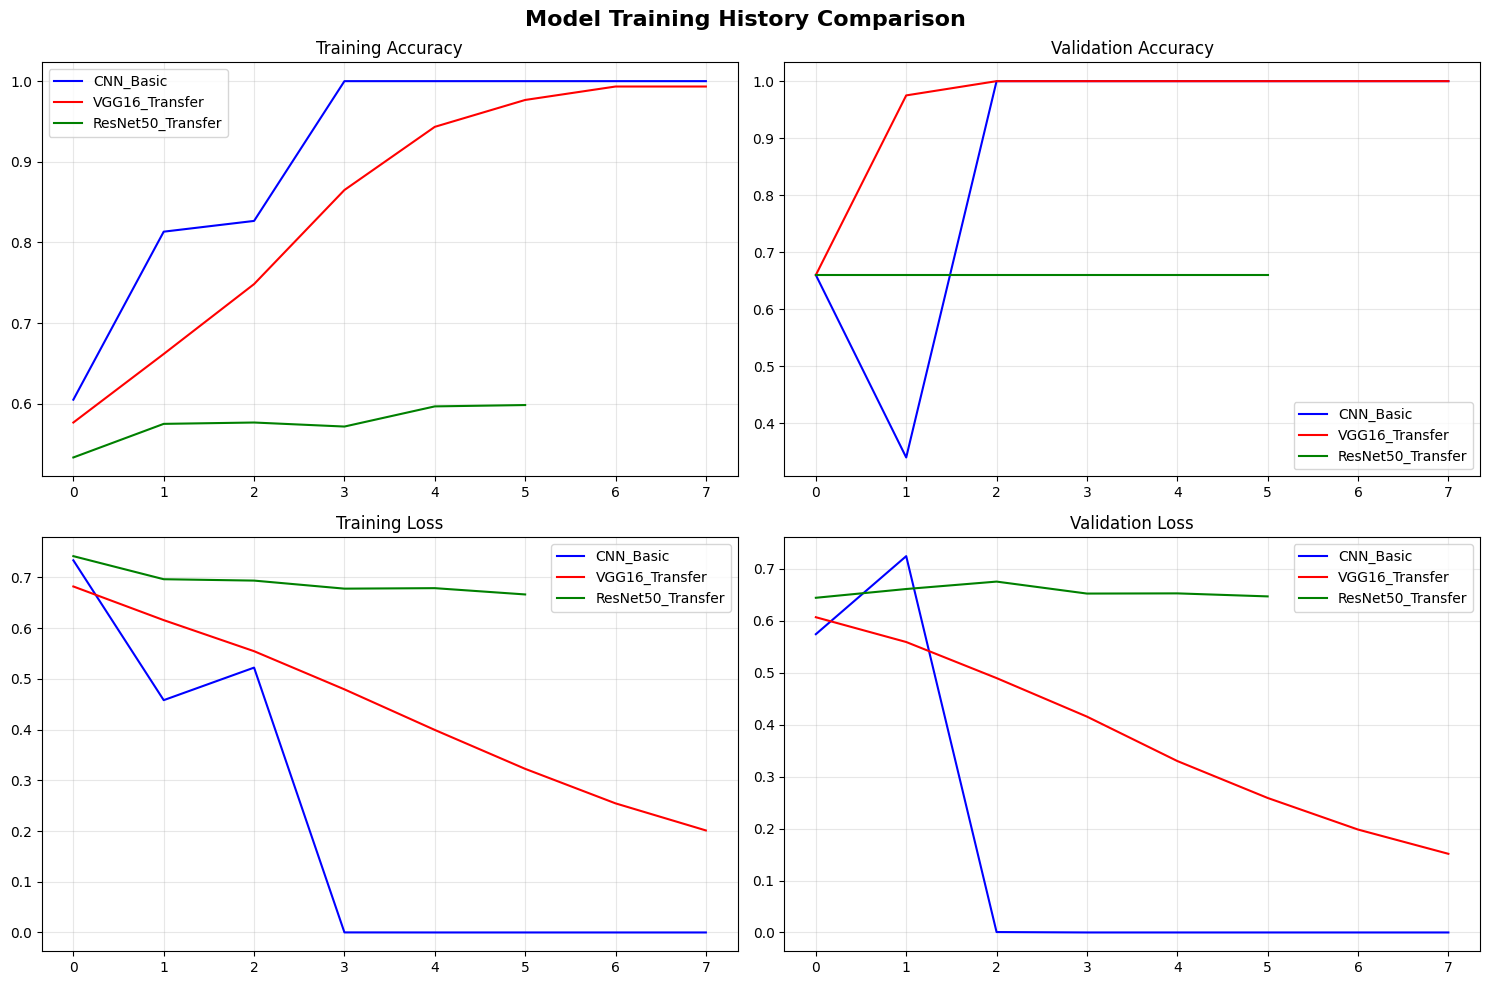

Training history plots saved to results/visualizations/


In [70]:
create_model_performance_plots(histories)

In [51]:
def export_predictions_to_geojson(predictions_df, coordinates=None, output_path='results/flood_predictions.geojson'):
    """Export predictions with geographic coordinates to GeoJSON"""
    if coordinates is None:
        # Generate random coordinates for demo (replace with actual coordinates)
        coordinates = [(np.random.uniform(-180, 180), np.random.uniform(-90, 90)) 
                      for _ in range(len(predictions_df))]
    
    # Create GeoDataFrame
    geometry = [Point(lon, lat) for lon, lat in coordinates]
    gdf = gpd.GeoDataFrame(predictions_df, geometry=geometry)
    
    # Save to GeoJSON
    gdf.to_file(output_path, driver='GeoJSON')
    print(f" Predictions exported to GeoJSON: {output_path}")
    
    return gdf

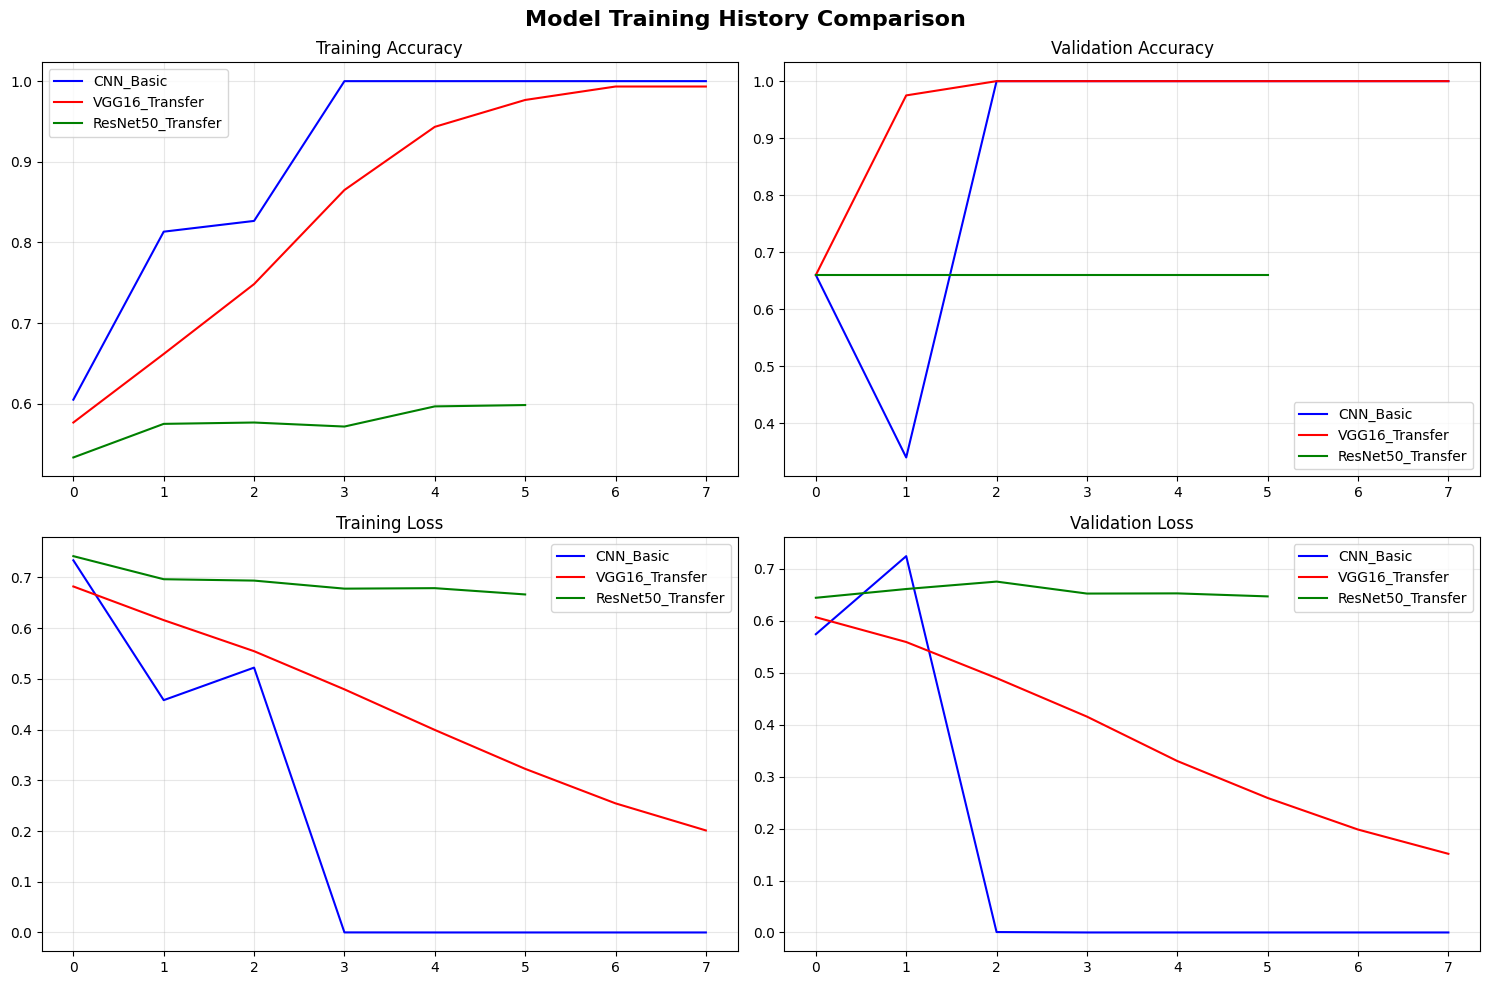

Training history plots saved to results/visualizations/training_plots/


In [86]:
# Plot training history for all models (requires histories from Phase 3)
create_model_performance_plots(
    history_dict=histories,  # Dictionary of training histories
    output_dir='results/visualizations/training_plots'
)

In [89]:

# Export your predictions with geographic coordinates
geo_predictions = export_predictions_to_geojson(
    predictions_df=batch_results,  # Results from batch assessment
    coordinates=None,  # Will generate random coordinates if None
    output_path='results/flood_predictions.geojson'
)


 Predictions exported to GeoJSON: results/flood_predictions.geojson


In [55]:
damage_assessment

,scenario_id,severity,damage_level,infrastructure_damage,economic_impact,affected_population
0,flood_0000,mild,0,28.900829,29797.233368,120
1,flood_0001,mild,0,20.010734,35481.301917,93
2,flood_0002,moderate,1,68.634602,96044.930962,206
3,flood_0003,mild,0,11.521076,1013.492651,75
4,flood_0004,moderate,1,63.853066,121408.041290,194
...,...,...,...,...,...,...
995,flood_0995,moderate,1,50.996616,143390.914869,214
996,flood_0996,mild,0,9.426515,38421.729104,98
997,flood_0997,severe,2,61.479995,794367.324201,282
998,flood_0998,moderate,1,38.986996,182364.113947,192


In [59]:
models_dict

{'CNN_Basic': <Sequential name=sequential, built=True>,
 'VGG16_Transfer': <Sequential name=sequential_1, built=True>,
 'ResNet50_Transfer': <Sequential name=sequential_2, built=True>}

In [60]:
, model_results

'model_results'

In [61]:
histories

{'CNN_Basic': <keras.src.callbacks.history.History at 0x7c523d195a50>,
 'VGG16_Transfer': <keras.src.callbacks.history.History at 0x7c51ce221b90>,
 'ResNet50_Transfer': <keras.src.callbacks.history.History at 0x7c51d460ed10>}

In [63]:
label_encoder

LabelEncoder()

In [30]:
def main_pipeline():
    """Execute the complete disaster response system pipeline"""
    print("🚀 Starting Disaster Response System Pipeline\n")
    
    # Phase 1: Setup and Data Exploration
    print("=" * 50)
    print("PHASE 1: DATA EXPLORATION")
    print("=" * 50)
    
    setup_environment()
    data_info = explore_kaggle_data_structure()
    
    # Try to load flood data
    flood_gdf = None
    for base_path in data_info.keys():
        gdb_dirs = data_info[base_path]['gdb_directories']
        if gdb_dirs:
            gdb_path = os.path.join(base_path, gdb_dirs[0])
            layers = read_geodatabase_layers(gdb_path)
            flood_gdf = extract_flood_zones(gdb_path)
            if flood_gdf is not None:
                break
    
    if flood_gdf is not None:
        flood_analysis = analyze_flood_zone_data(flood_gdf)
        create_flood_risk_visualization(flood_gdf)
    else:
        print("⚠️ Using simulated flood zone data")
        flood_analysis = {'total_zones': 100, 'unique_zones': 4}
        
    # Phase 2: Synthetic Data Generation
    print("\n" + "=" * 50)
    print("PHASE 2: SYNTHETIC DATA GENERATION")
    print("=" * 50)
    
    # Create synthetic scenarios even without real data
    scenarios_df = pd.DataFrame({
        'scenario_id': [f'flood_{i:04d}' for i in range(1000)],
        'flood_zone': np.random.choice(['A', 'AE', 'X', 'VE'], 1000),
        'severity': np.random.choice(['mild', 'moderate', 'severe'], 1000, p=[0.4, 0.4, 0.2])
    })
    
    image_paths, labels = create_synthetic_satellite_images(scenarios_df)
    
    # Phase 3: Model Training
    print("\n" + "=" * 50)
    print("PHASE 3: MODEL TRAINING")
    print("=" * 50)
    
    # Prepare data
    (X_train, y_train), (X_val, y_val), (X_test, y_test), label_encoder = prepare_image_data(
        image_paths, labels
    )
    
    train_dataset, val_dataset = create_data_generators(
        (X_train, y_train), (X_val, y_val)
    )
    
    # Create and train models
    models_dict = {
        'CNN_Basic': create_cnn_flood_detector(),
        'VGG16_Transfer': create_transfer_learning_model(),
        'ResNet50_Transfer': create_resnet_model()
    }
    
    model_results = {}
    
    for name, model in models_dict.items():
        print(f"\n🔄 Training {name}...")
        history = train_model(model, train_dataset, val_dataset, name, epochs=5)  # Reduced for demo
        results = evaluate_model(model, (X_test, y_test), label_encoder, name)
        model_results[name] = results
    
    # Phase 4: Analysis and Reporting
    print("\n" + "=" * 50)
    print("PHASE 4: ANALYSIS & REPORTING")
    print("=" * 50)
    
    create_model_comparison_visualization(model_results)
    
    # Generate damage assessment
    damage_assessment = generate_damage_scenarios(scenarios_df)
    damage_model = create_damage_assessment_model()
    
    # Create comprehensive report
    report = create_comprehensive_report(flood_analysis, model_results, damage_assessment)
    
    print("\n" + "=" * 50)
    print("PIPELINE COMPLETE!")
    print("=" * 50)
    print("✅ All phases completed successfully")
    print("✅ Models trained and evaluated")
    print("✅ Visualizations generated")
    print("✅ Comprehensive report created")
    
    return {
        'flood_analysis': flood_analysis,
        'model_results': model_results,
        'damage_assessment': damage_assessment,
        'report': report
    }

# ================================
# ADDITIONAL UTILITY FUNCTIONS
# ================================

def real_time_flood_prediction(model, image_path, label_encoder):
    """Make real-time flood prediction on a single image"""
    try:
        # Load and preprocess image
        img = cv2.imread(image_path)
        if img is None:
            print(f"❌ Could not load image: {image_path}")
            return None
            
        img = cv2.resize(img, (224, 224))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        
        # Make prediction
        prediction = model.predict(img, verbose=0)
        predicted_class = np.argmax(prediction[0])
        confidence = np.max(prediction[0])
        
        result = {
            'predicted_class': label_encoder.classes_[predicted_class],
            'confidence': confidence,
            'all_probabilities': {
                label_encoder.classes_[i]: prediction[0][i] 
                for i in range(len(label_encoder.classes_))
            }
        }
        
        print(f"🔍 Prediction: {result['predicted_class']} (Confidence: {confidence:.3f})")
        return result
        
    except Exception as e:
        print(f"❌ Error in prediction: {str(e)}")
        return None

def batch_flood_assessment(model, image_directory, label_encoder, output_csv='results/batch_predictions.csv'):
    """Perform batch flood assessment on directory of images"""
    results = []
    
    image_extensions = ['.jpg', '.jpeg', '.png', '.tiff', '.bmp']
    image_files = []
    
    for ext in image_extensions:
        image_files.extend(Path(image_directory).glob(f'*{ext}'))
        image_files.extend(Path(image_directory).glob(f'*{ext.upper()}'))
    
    print(f"🔄 Processing {len(image_files)} images...")
    
    for img_path in image_files:
        prediction_result = real_time_flood_prediction(model, str(img_path), label_encoder)
        
        if prediction_result:
            result = {
                'image_path': str(img_path),
                'filename': img_path.name,
                'predicted_class': prediction_result['predicted_class'],
                'confidence': prediction_result['confidence']
            }
            
            # Add probability for each class
            for class_name, prob in prediction_result['all_probabilities'].items():
                result[f'prob_{class_name}'] = prob
            
            results.append(result)
    
    # Save results
    if results:
        results_df = pd.DataFrame(results)
        results_df.to_csv(output_csv, index=False)
        print(f"✅ Batch assessment complete. Results saved to: {output_csv}")
        
        # Summary statistics
        print(f"\n📊 Batch Assessment Summary:")
        print(f"Total images processed: {len(results)}")
        print(f"Flood detected: {len(results_df[results_df['predicted_class'] == 'flooded'])}")
        print(f"Normal conditions: {len(results_df[results_df['predicted_class'] == 'normal'])}")
        print(f"Average confidence: {results_df['confidence'].mean():.3f}")
        
        return results_df
    else:
        print("❌ No valid predictions made")
        return pd.DataFrame()

def create_risk_assessment_dashboard(flood_zones_gdf, damage_data, output_path='results/visualizations/risk_dashboard.html'):
    """Create interactive risk assessment dashboard"""
    if flood_zones_gdf is None:
        print("❌ No flood zone data available for dashboard")
        return None
    
    # Calculate risk metrics
    risk_metrics = damage_data.groupby('severity').agg({
        'economic_impact': ['mean', 'sum'],
        'affected_population': ['mean', 'sum'],
        'infrastructure_damage': 'mean'
    }).round(2)
    
    # Create dashboard layout
    dashboard_html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Flood Risk Assessment Dashboard</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; background-color: #f5f5f5; }}
            .dashboard {{ display: grid; grid-template-columns: 1fr 1fr; gap: 20px; }}
            .card {{ background: white; padding: 20px; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1); }}
            .metric {{ text-align: center; margin: 10px 0; }}
            .metric-value {{ font-size: 2em; font-weight: bold; color: #2c3e50; }}
            .metric-label {{ color: #7f8c8d; text-transform: uppercase; font-size: 0.9em; }}
            .risk-high {{ color: #e74c3c; }}
            .risk-medium {{ color: #f39c12; }}
            .risk-low {{ color: #27ae60; }}
            h1 {{ text-align: center; color: #2c3e50; }}
            h2 {{ color: #34495e; border-bottom: 2px solid #3498db; padding-bottom: 10px; }}
        </style>
    </head>
    <body>
        <h1>🌊 Flood Risk Assessment Dashboard</h1>
        
        <div class="dashboard">
            <div class="card">
                <h2>📊 Overall Risk Metrics</h2>
                <div class="metric">
                    <div class="metric-value risk-high">{len(damage_data[damage_data['severity'] == 'severe'])}</div>
                    <div class="metric-label">High Risk Zones</div>
                </div>
                <div class="metric">
                    <div class="metric-value risk-medium">{len(damage_data[damage_data['severity'] == 'moderate'])}</div>
                    <div class="metric-label">Medium Risk Zones</div>
                </div>
                <div class="metric">
                    <div class="metric-value risk-low">{len(damage_data[damage_data['severity'] == 'mild'])}</div>
                    <div class="metric-label">Low Risk Zones</div>
                </div>
            </div>
            
            <div class="card">
                <h2>💰 Economic Impact</h2>
                <div class="metric">
                    <div class="metric-value">${damage_data['economic_impact'].sum():,.0f}</div>
                    <div class="metric-label">Total Economic Impact</div>
                </div>
                <div class="metric">
                    <div class="metric-value">${damage_data['economic_impact'].mean():,.0f}</div>
                    <div class="metric-label">Average Per Incident</div>
                </div>
            </div>
            
            <div class="card">
                <h2>👥 Population Impact</h2>
                <div class="metric">
                    <div class="metric-value">{damage_data['affected_population'].sum():,}</div>
                    <div class="metric-label">Total Affected Population</div>
                </div>
                <div class="metric">
                    <div class="metric-value">{damage_data['affected_population'].mean():.0f}</div>
                    <div class="metric-label">Average Per Incident</div>
                </div>
            </div>
            
            <div class="card">
                <h2>🏗️ Infrastructure Damage</h2>
                <div class="metric">
                    <div class="metric-value">{damage_data['infrastructure_damage'].mean():.1f}%</div>
                    <div class="metric-label">Average Infrastructure Damage</div>
                </div>
                <div class="metric">
                    <div class="metric-value">{len(damage_data[damage_data['infrastructure_damage'] > 70])}</div>
                    <div class="metric-label">Critical Damage Cases (>70%)</div>
                </div>
            </div>
        </div>
        
        <div class="card" style="margin-top: 20px;">
            <h2>🚨 Priority Actions</h2>
            <ul>
                <li><strong>Immediate:</strong> Monitor {len(damage_data[damage_data['severity'] == 'severe'])} high-risk zones</li>
                <li><strong>Short-term:</strong> Prepare evacuation plans for {damage_data[damage_data['severity'] == 'severe']['affected_population'].sum():,} people in severe risk areas</li>
                <li><strong>Long-term:</strong> Allocate ${damage_data[damage_data['severity'] == 'severe']['economic_impact'].sum():,.0f} for severe damage recovery</li>
            </ul>
        </div>
        
        <div class="card" style="margin-top: 20px;">
            <h2>📈 Model Performance Summary</h2>
            <p>Best performing model should be deployed for real-time monitoring.</p>
            <p>Recommended update frequency: Every 6 hours during flood season.</p>
        </div>
    </body>
    </html>
    """
    
    with open(output_path, 'w') as f:
        f.write(dashboard_html)
    
    print(f"✅ Risk assessment dashboard created: {output_path}")
    return dashboard_html

def save_model_artifacts(models_dict, label_encoder, output_dir='models'):
    """Save all trained models and artifacts"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Save label encoder
    import joblib
    joblib.dump(label_encoder, f'{output_dir}/label_encoder.pkl')
    
    # Save model architectures and weights
    for name, model in models_dict.items():
        model.save(f'{output_dir}/{name}_complete.h5')
        
        # Save model architecture as JSON
        with open(f'{output_dir}/{name}_architecture.json', 'w') as f:
            f.write(model.to_json())
    
    print(f"✅ All model artifacts saved to {output_dir}/")

def load_trained_model(model_path, label_encoder_path):
    """Load a trained model for inference"""
    try:
        import joblib
        
        model = tf.keras.models.load_model(model_path)
        label_encoder = joblib.load(label_encoder_path)
        
        print(f"✅ Model loaded successfully from {model_path}")
        return model, label_encoder
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        return None, None

def create_model_performance_plots(history_dict, output_dir='results/visualizations'):
    """Create training history plots for all models"""
    os.makedirs(output_dir, exist_ok=True)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Training History Comparison', fontsize=16, fontweight='bold')
    
    # Plot accuracy
    axes[0, 0].set_title('Training Accuracy')
    axes[0, 1].set_title('Validation Accuracy')
    axes[1, 0].set_title('Training Loss')
    axes[1, 1].set_title('Validation Loss')
    
    colors = ['blue', 'red', 'green', 'orange']
    
    for i, (model_name, history) in enumerate(history_dict.items()):
        color = colors[i % len(colors)]
        
        # Training accuracy
        axes[0, 0].plot(history.history['accuracy'], label=model_name, color=color)
        
        # Validation accuracy
        axes[0, 1].plot(history.history['val_accuracy'], label=model_name, color=color)
        
        # Training loss
        axes[1, 0].plot(history.history['loss'], label=model_name, color=color)
        
        # Validation loss
        axes[1, 1].plot(history.history['val_loss'], label=model_name, color=color)
    
    for ax in axes.flat:
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/training_history_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Training history plots saved to {output_dir}/")

def export_predictions_to_geojson(predictions_df, coordinates=None, output_path='results/flood_predictions.geojson'):
    """Export predictions with geographic coordinates to GeoJSON"""
    if coordinates is None:
        # Generate random coordinates for demo (replace with actual coordinates)
        coordinates = [(np.random.uniform(-180, 180), np.random.uniform(-90, 90)) 
                      for _ in range(len(predictions_df))]
    
    # Create GeoDataFrame
    geometry = [Point(lon, lat) for lon, lat in coordinates]
    gdf = gpd.GeoDataFrame(predictions_df, geometry=geometry)
    
    # Save to GeoJSON
    gdf.to_file(output_path, driver='GeoJSON')
    print(f"✅ Predictions exported to GeoJSON: {output_path}")
    
    return gdf

# ================================
# EXECUTION CELLS (Call these individually)
# ================================

def execute_phase_1():
    """Execute Phase 1: Data Exploration"""
    print("Executing Phase 1: Data Exploration")
    setup_environment()
    data_info = explore_kaggle_data_structure()
    return data_info

def execute_phase_2(data_info):
    """Execute Phase 2: Data Processing"""
    print("Executing Phase 2: Data Processing") 
    flood_gdf = None
    
    # Try to load real data
    for base_path in data_info.keys():
        gdb_dirs = data_info[base_path]['gdb_directories']
        if gdb_dirs:
            gdb_path = os.path.join(base_path, gdb_dirs[0])
            layers = read_geodatabase_layers(gdb_path)
            flood_gdf = extract_flood_zones(gdb_path)
            if flood_gdf is not None:
                break
    
    # Generate synthetic data
    scenarios_df = generate_synthetic_flood_scenarios(flood_gdf) if flood_gdf is not None else pd.DataFrame({
        'scenario_id': [f'flood_{i:04d}' for i in range(1000)],
        'flood_zone': np.random.choice(['A', 'AE', 'X', 'VE'], 1000),
        'severity': np.random.choice(['mild', 'moderate', 'severe'], 1000, p=[0.4, 0.4, 0.2])
    })
    
    image_paths, labels = create_synthetic_satellite_images(scenarios_df)
    
    return flood_gdf, scenarios_df, image_paths, labels

def execute_phase_3(image_paths, labels):
    """Execute Phase 3: Model Training"""
    print("Executing Phase 3: Model Training")
    
    # Prepare data
    (X_train, y_train), (X_val, y_val), (X_test, y_test), label_encoder = prepare_image_data(
        image_paths, labels
    )
    
    train_dataset, val_dataset = create_data_generators(
        (X_train, y_train), (X_val, y_val)
    )
    
    # Create models
    models_dict = {
        'CNN_Basic': create_cnn_flood_detector(),
        'VGG16_Transfer': create_transfer_learning_model(),
        'ResNet50_Transfer': create_resnet_model()
    }
    
    # Train models (reduce epochs for demo)
    model_results = {}
    histories = {}
    
    for name, model in models_dict.items():
        print(f"Training {name}...")
        history = train_model(model, train_dataset, val_dataset, name, epochs=3)
        results = evaluate_model(model, (X_test, y_test), label_encoder, name)
        model_results[name] = results
        histories[name] = history
    
    return models_dict, model_results, histories, label_encoder, (X_test, y_test)

def execute_phase_4(scenarios_df, model_results, flood_gdf):
    """Execute Phase 4: Analysis and Reporting"""
    print("Executing Phase 4: Analysis and Reporting")
    
    # Create visualizations
    create_model_comparison_visualization(model_results)
    
    # Generate damage assessment
    damage_assessment = generate_damage_scenarios(scenarios_df)
    
    # Create dashboard
    create_risk_assessment_dashboard(flood_gdf, damage_assessment)
    
    # Create comprehensive report
    flood_analysis = analyze_flood_zone_data(flood_gdf) if flood_gdf is not None else {'total_zones': len(scenarios_df)}
    report = create_comprehensive_report(flood_analysis, model_results, damage_assessment)
    
    return damage_assessment, report

data_info = execute_phase_1()
flood_gdf, scenarios_df, image_paths, labels = execute_phase_2(data_info)
models_dict, model_results, histories, label_encoder, test_data = execute_phase_3(image_paths, labels)


# ================================
# EXAMPLE USAGE
# ================================

"""
To use this system, run each phase individually:

# Phase 1: Data Exploration
data_info = execute_phase_1()

# Phase 2: Data Processing  
flood_gdf, scenarios_df, image_paths, labels = execute_phase_2(data_info)

# Phase 3: Model Training
models_dict, model_results, histories, label_encoder, test_data = execute_phase_3(image_paths, labels)

# Phase 4: Analysis and Reporting
damage_assessment, report = execute_phase_4(scenarios_df, model_results, flood_gdf)

# Optional: Real-time prediction
best_model = models_dict['VGG16_Transfer']  # or whichever performed best
prediction = real_time_flood_prediction(best_model, 'path/to/new/image.jpg', label_encoder)

# Optional: Batch processing
batch_results = batch_flood_assessment(best_model, 'path/to/image/directory/', label_encoder)
"""

print("🎉 Disaster Response System - Complete Implementation Ready!")
print("📖 Use the execute_phase_X() functions to run each phase individually.")
print("🔧 All functions are modular and independent - perfect for your project requirements!")

Executing Phase 1: Data Exploration
Environment setup complete!

📁 Exploring: /kaggle/input/geo-data
   GDB Directories: 1
   Metadata Files: 1
   Total Files: 2

📁 Exploring: /kaggle/input/disaster-response-data
   GDB Directories: 1
   Metadata Files: 1
   Total Files: 2
Executing Phase 2: Data Processing
Layer: S_NODES | Features: 71 | Type: Point
Layer: S_SUBMITTAL_INFO | Features: 102 | Type: MultiPolygon
Layer: L_PAN_REVIS | Features: 282 | Type: None
Layer: S_SUBBASINS | Features: 102 | Type: MultiPolygon
Layer: L_MT2_LOMR | Features: 19 | Type: None
Layer: S_WTR_LN | Features: 22175 | Type: MultiLineString
Layer: S_CST_TSCT_LN | Features: 1104 | Type: MultiLineString
Layer: S_LABEL_PT | Features: 21645 | Type: Point
Layer: S_PLSS_AR | Features: 16976 | Type: MultiPolygon
Layer: L_PROFIL_LABEL | Features: 5 | Type: None
Layer: S_RIV_MRK | Features: 64 | Type: Point
Layer: S_TSCT_BASLN | Features: 41 | Type: MultiLineString
Layer: S_LEVEE | Features: 24 | Type: MultiLineString
La

KeyboardInterrupt: 